# Distance Euclidienne

In [12]:
from cookie_clusters import *

In [30]:
import os
import rasterio as rio
import fastdtw as dtw
import re
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from scipy.spatial.distance import euclidean

In [31]:
# List and dict of target pixels
pixels_de_interet, dic_de_pixels = create_dic_pixels()

In [32]:
dir = "../../ressources/images"
images_list = os.listdir(dir)

images_2A = list()
images_2B = list()
prog = re.compile(r'\w+2A')
for image in images_list:
    if prog.match(image):
        images_2A.append(image)
    else:
        images_2B.append(image)
        
images_2A.sort()
images_2B.sort()
all_images = images_2A + images_2B
all_images = sorted(all_images, key=lambda date: date[16:24])    

In [33]:
# Here you can chose the list of images you want to use.
list_to_use = all_images
line = 0
matrice_rouge = np.zeros((len(pixels_de_interet), len(list_to_use)))
matrice_vert = np.zeros((len(pixels_de_interet), len(list_to_use)))
matrice_bleu = np.zeros((len(pixels_de_interet), len(list_to_use)))
matrice_nir = np.zeros((len(pixels_de_interet), len(list_to_use)))
matrice_ndvi = np.zeros((len(pixels_de_interet), len(list_to_use)))
matrice_ndwi = np.zeros((len(pixels_de_interet), len(list_to_use)))

for image in list_to_use:
    with rio.open(dir+'/'+image, 'r') as ds:
        band1 = ds.read(1) # Near Infrared
        band2 = ds.read(2) # Red
        band3 = ds.read(3) # Green
        band4 = ds.read(4) # Blue
        ndvi = (band1-band2)/(band1+band2) # Normalized Difference Vegetation Index
        ndvi = np.nan_to_num(ndvi)
        ndwi = (band3-band1)/(band3+band1) # Normalized Difference Water Index
        ndwi = np.nan_to_num(ndwi)
    # Extraction of target pixels
    for pixel,j in zip(pixels_de_interet, range(len(pixels_de_interet))):
        matrice_vert[j,line] = band3[pixel[0], pixel[1]]
        matrice_rouge[j,line] = band2[pixel[0], pixel[1]]
        matrice_bleu[j,line] = band4[pixel[0], pixel[1]]
        matrice_nir[j,line] = band1[pixel[0], pixel[1]]
        matrice_ndvi[j,line] = ndvi[pixel[0], pixel[1]]
        matrice_ndwi[j,line] = ndwi[pixel[0], pixel[1]]
    line +=1

/tmp/ipykernel_980/3287012591.py:17: RuntimeWarning: invalid value encountered in divide
  ndvi = (band1-band2)/(band1+band2) # Normalized Difference Vegetation Index
/tmp/ipykernel_980/3287012591.py:19: RuntimeWarning: invalid value encountered in divide
  ndwi = (band3-band1)/(band3+band1) # Normalized Difference Water Index


On definit une fonction pour generer un matrice de distances DTW à utiliser dans les diverses méthodes de clustering.

In [34]:
def matrice_dtw(X, distance):
  n=len(X)
  r=np.zeros((n,n))
  for i in range(n):
    for j in range(n):
        r[i,j]= dtw.fastdtw(X[i].reshape(1,-1),X[j].reshape(1,-1),dist=distance)[0]
  return r

In [35]:
matrice_rouge_dtw = matrice_dtw(matrice_rouge, distance=euclidean)

(54, 141)


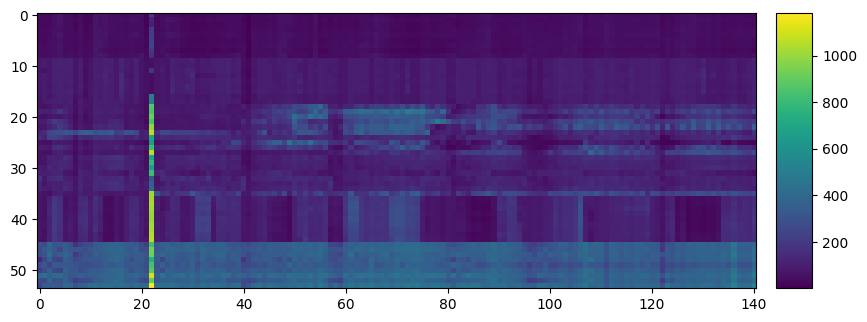

In [36]:
print(matrice_vert.shape)
#Looking for a pixels
img = (matrice_vert/8).astype(int)
#grayImage = cv2.cvtColor(uint_img, cv2.COLOR_GRAY2BGR)
plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(img)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)
plt.show()

# DBSCAN

### Bande verte

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0, -1, -1, -1,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
        1,  1,  1])

Nombre de clusters: 2
Nombre de points aberrantes: 7


,accuracy,f1_score
0,0.382979,0.230496


,calinski_harabasz_score
0,97.49862


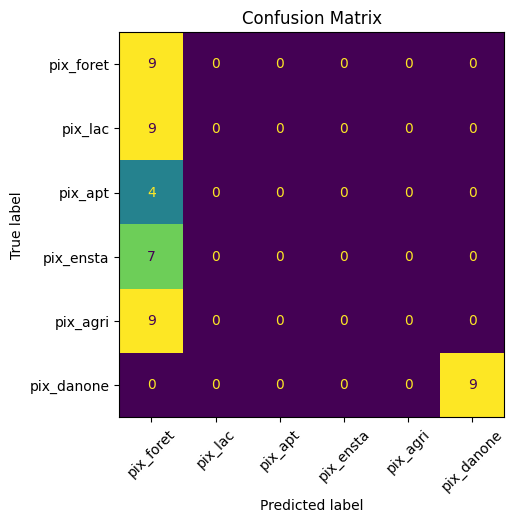

In [37]:
matrice = np.delete(matrice_vert,22,1)
db_ = DBSCAN(eps=6000, min_samples=3, metric='precomputed').fit(matrice_dtw(matrice, euclidean))
yhat = db_.labels_
display(yhat)
n_clusters = len(set(yhat)) - (1 if -1 in yhat else 0)
n_aberrantes = list(yhat).count(-1)
print("Nombre de clusters: %d" % n_clusters)
print("Nombre de points aberrantes: %d" % n_aberrantes)
eval_ = evaluator_de_experiences(yhat, pixels_de_interet, dic_de_pixels, matrice)
eval_.confusion_matrix()
display(eval_.metrics_classif())
display(eval_.metrics_clustering())

### Bande bleu

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0, -1, -1, -1,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
        1,  1,  1])

Nombre de clusters: 2
Nombre de point aberrantes: 7


,accuracy,f1_score
0,0.382979,0.230496


,calinski_harabasz_score
0,110.329286


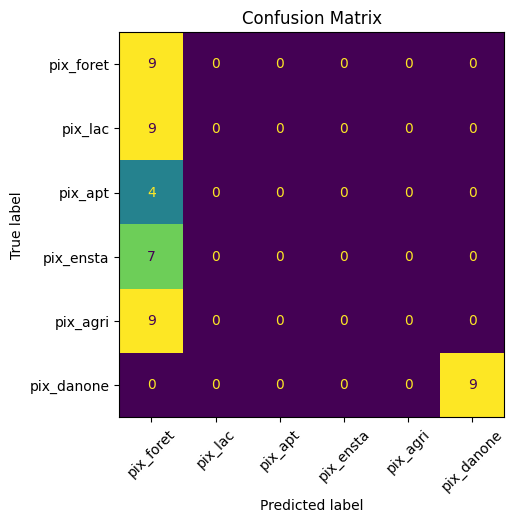

In [38]:
matrice = np.delete(matrice_bleu,22,1)
db_ = DBSCAN(eps=6000, min_samples=3, metric='precomputed').fit(matrice_dtw(matrice, euclidean))
yhat = db_.labels_
display(yhat)
n_clusters = len(set(yhat)) - (1 if -1 in yhat else 0)
n_aberrantes = list(yhat).count(-1)
print("Nombre de clusters: %d" % n_clusters)
print("Nombre de point aberrantes: %d" % n_aberrantes)
eval_ = evaluator_de_experiences(yhat, pixels_de_interet, dic_de_pixels, matrice)
eval_.confusion_matrix()
display(eval_.metrics_classif())
display(eval_.metrics_clustering())

### Bande rouge

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  0,  1,  1, -1,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,
        0, -1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
        3,  3,  3])

Nombre de clusters: 4
Nombre de point aberrantes: 4


,accuracy,f1_score
0,0.6,0.512281


,calinski_harabasz_score
0,61.331305


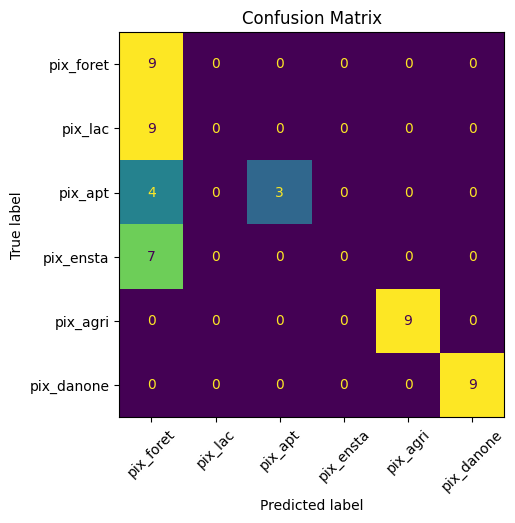

In [39]:
matrice = np.delete(matrice_rouge,22,1)
db_ = DBSCAN(eps=8000, min_samples=4, metric='precomputed').fit(matrice_dtw(matrice, euclidean))
yhat = db_.labels_
display(yhat)
n_clusters = len(set(yhat)) - (1 if -1 in yhat else 0)
n_aberrantes = list(yhat).count(-1)
print("Nombre de clusters: %d" % n_clusters)
print("Nombre de point aberrantes: %d" % n_aberrantes)
eval_ = evaluator_de_experiences(yhat, pixels_de_interet, dic_de_pixels, matrice)
eval_.confusion_matrix()
display(eval_.metrics_classif())
display(eval_.metrics_clustering())

### Bande NIR

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  2,  2,  2,  2,  2, -1,  2, -1,  2,  2,  2,  2,  2,  4,  2,  2,
        2, -1,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
        4,  4,  4])

Nombre de clusters: 5
Nombre de point aberrantes: 3


,accuracy,f1_score
0,0.843137,0.769006


,calinski_harabasz_score
0,96.248815


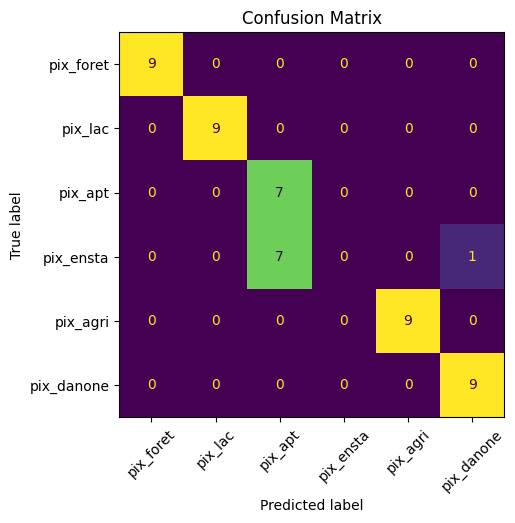

In [40]:
matrice = np.delete(matrice_nir,22,1)
db_ = DBSCAN(eps=7000, min_samples=4, metric='precomputed').fit(matrice_dtw(matrice, euclidean))
yhat = db_.labels_
display(yhat)
n_clusters = len(set(yhat)) - (1 if -1 in yhat else 0)
n_aberrantes = list(yhat).count(-1)
print("Nombre de clusters: %d" % n_clusters)
print("Nombre de point aberrantes: %d" % n_aberrantes)
eval_ = evaluator_de_experiences(yhat, pixels_de_interet, dic_de_pixels, matrice)
eval_.confusion_matrix()
display(eval_.metrics_classif())
display(eval_.metrics_clustering())

### Bande NDVI

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  2,  2,  2,  2,
        2,  2,  2])

Nombre de clusters: 4
Nombre de point aberrantes: 1


,accuracy,f1_score
0,0.660377,0.583333


,calinski_harabasz_score
0,130.819708


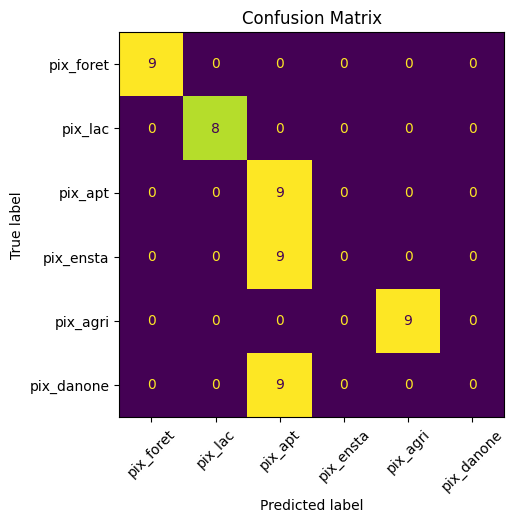

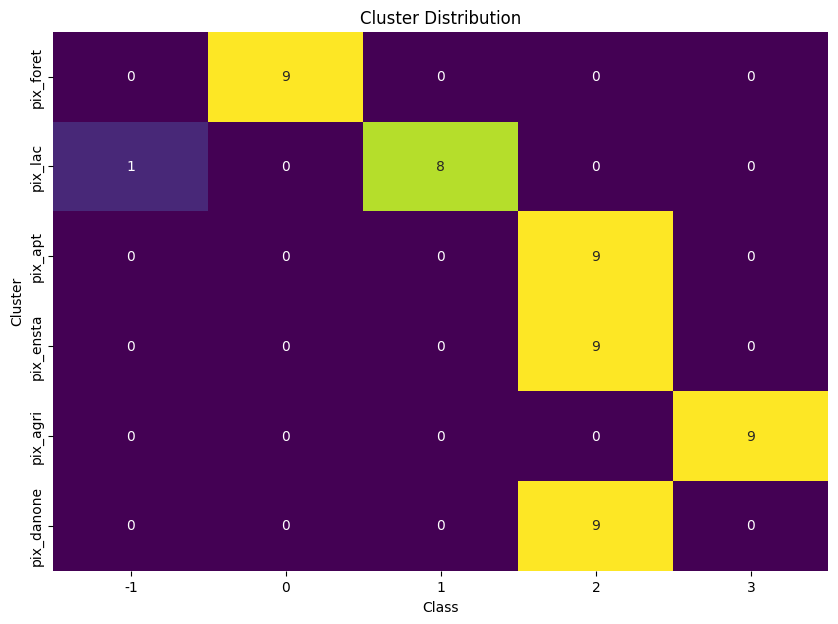

None

In [41]:
matrice = np.delete(matrice_ndvi,22,1)
db_ = DBSCAN(eps=2.5, min_samples=4, metric='precomputed').fit(matrice_dtw(matrice, euclidean))
yhat = db_.labels_
display(yhat)
n_clusters = len(set(yhat)) - (1 if -1 in yhat else 0)
n_aberrantes = list(yhat).count(-1)
print("Nombre de clusters: %d" % n_clusters)
print("Nombre de point aberrantes: %d" % n_aberrantes)
eval_ = evaluator_de_experiences(yhat, pixels_de_interet, dic_de_pixels, matrice)
eval_.confusion_matrix()
display(eval_.metrics_classif())
display(eval_.metrics_clustering())
display(eval_.cluster_distribution())

### Bande NDWI

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  2,  2,  2,  2,  2,  3,  3,  2,  2, -1,  3,  3,  3,  3,  3,  3,
        3,  2,  4,  4,  4,  4,  4,  4,  4,  4,  4,  3,  3,  3,  3,  3,  3,
        3,  3,  3])

Nombre de clusters: 5
Nombre de point aberrantes: 2


,accuracy,f1_score
0,0.807692,0.748366


,calinski_harabasz_score
0,109.97741


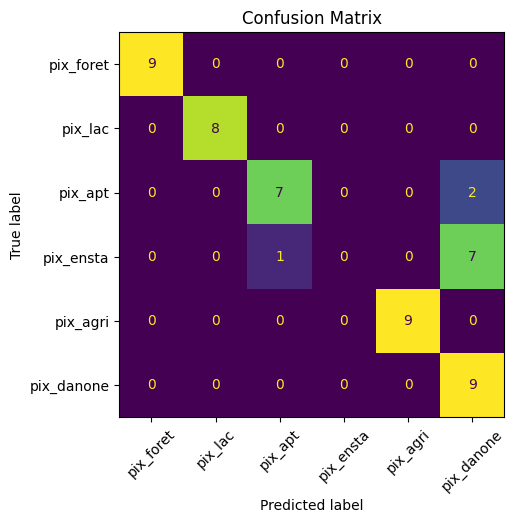

In [14]:
matrice = np.delete(matrice_ndwi,22,1)
db_ = DBSCAN(eps=2, min_samples=4, metric='precomputed').fit(matrice_dtw(matrice, euclidean))
yhat = db_.labels_
display(yhat)
n_clusters = len(set(yhat)) - (1 if -1 in yhat else 0)
n_aberrantes = list(yhat).count(-1)
print("Nombre de clusters: %d" % n_clusters)
print("Nombre de point aberrantes: %d" % n_aberrantes)
eval_ = evaluator_de_experiences(yhat, pixels_de_interet, dic_de_pixels, matrice)
eval_.confusion_matrix()
display(eval_.metrics_classif())
display(eval_.metrics_clustering())

# OPTICS

### Bande verte

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2,  2,  2,  1,  2,  2,
        2, -1,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
        4,  4,  4])

Nombre de clusters: 5
Nombre de point aberrantes: 10


,accuracy,f1_score
0,0.954545,0.802969


,calinski_harabasz_score
0,81.2884


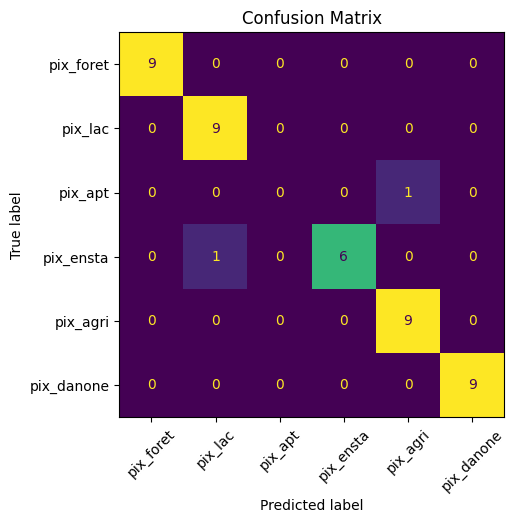

In [15]:
matrice = np.delete(matrice_vert,22,1)
opt_ = OPTICS(eps=6000, metric='precomputed').fit(matrice_dtw(matrice, euclidean))
yhat = opt_.labels_
display(yhat)
n_clusters = len(set(yhat)) - (1 if -1 in yhat else 0)
n_aberrantes = list(yhat).count(-1)
print("Nombre de clusters: %d" % n_clusters)
print("Nombre de point aberrantes: %d" % n_aberrantes)
eval_ = evaluator_de_experiences(yhat, pixels_de_interet, dic_de_pixels, matrice)
eval_.confusion_matrix()
display(eval_.metrics_classif())
display(eval_.metrics_clustering())

### Bande blue

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  3, -1, -1, -1, -1, -1,  2, -1, -1, -1,  2,  2, -1,  1,  2,  2,
        2, -1,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
        4,  4,  4])

Nombre de clusters: 5
Nombre de point aberrantes: 10


,accuracy,f1_score
0,0.931818,0.788012


,calinski_harabasz_score
0,83.344056


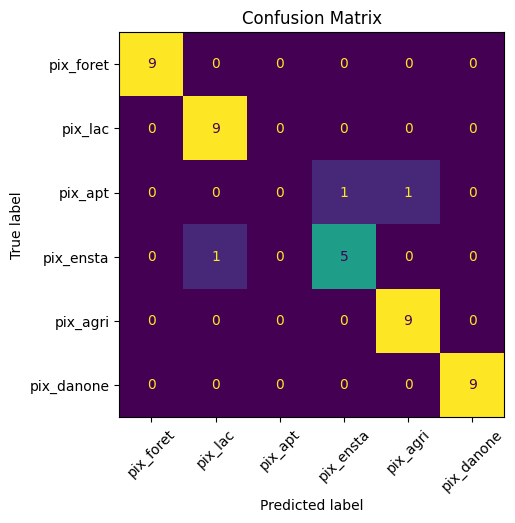

In [16]:
matrice = np.delete(matrice_bleu,22,1)
opt_ = OPTICS(eps=6000, metric='precomputed').fit(matrice_dtw(matrice, euclidean))
yhat = opt_.labels_
display(yhat)
n_clusters = len(set(yhat)) - (1 if -1 in yhat else 0)
n_aberrantes = list(yhat).count(-1)
print("Nombre de clusters: %d" % n_clusters)
print("Nombre de point aberrantes: %d" % n_aberrantes)
eval_ = evaluator_de_experiences(yhat, pixels_de_interet, dic_de_pixels, matrice)
eval_.confusion_matrix()
display(eval_.metrics_classif())
display(eval_.metrics_clustering())

### Bande rouge

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1, -1, -1, -1, -1, -1,  2, -1, -1, -1,  2,  2,  2,  2,  2,  2,
        2, -1,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
        4,  4,  4])

Nombre de clusters: 5
Nombre de point aberrantes: 10


,accuracy,f1_score
0,0.977273,0.822222


,calinski_harabasz_score
0,106.257775


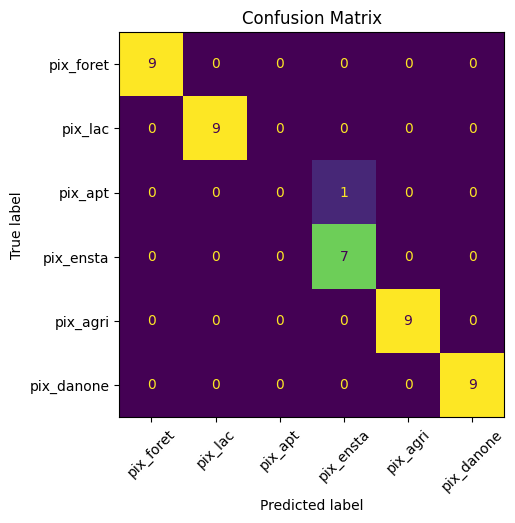

In [17]:
matrice = np.delete(matrice_rouge,22,1)
opt_ = OPTICS(eps=6000, metric='precomputed').fit(matrice_dtw(matrice, euclidean))
yhat = opt_.labels_
display(yhat)
n_clusters = len(set(yhat)) - (1 if -1 in yhat else 0)
n_aberrantes = list(yhat).count(-1)
print("Nombre de clusters: %d" % n_clusters)
print("Nombre de point aberrantes: %d" % n_aberrantes)
eval_ = evaluator_de_experiences(yhat, pixels_de_interet, dic_de_pixels, matrice)
eval_.confusion_matrix()
display(eval_.metrics_classif())
display(eval_.metrics_clustering())

### Bande NIR

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  2,  2,  2,  2,  2, -1,  2, -1,  2,  2,  2,  2,  2,  0,  2,  2,
        2, -1,  3,  3,  3,  3,  3,  3,  3,  3,  3,  1,  1,  1,  1,  1,  1,
        1,  1,  1])

Nombre de clusters: 5
Nombre de point aberrantes: 3


,accuracy,f1_score
0,0.843137,0.769006


,calinski_harabasz_score
0,95.103781


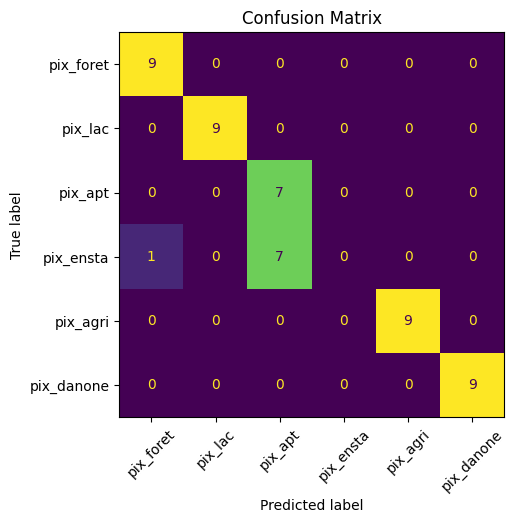

In [18]:
matrice = np.delete(matrice_nir,22,1)
opt_ = OPTICS(eps=6000, metric='precomputed').fit(matrice_dtw(matrice, euclidean))
yhat = opt_.labels_
display(yhat)
n_clusters = len(set(yhat)) - (1 if -1 in yhat else 0)
n_aberrantes = list(yhat).count(-1)
print("Nombre de clusters: %d" % n_clusters)
print("Nombre de point aberrantes: %d" % n_aberrantes)
eval_ = evaluator_de_experiences(yhat, pixels_de_interet, dic_de_pixels, matrice)
eval_.confusion_matrix()
display(eval_.metrics_classif())
display(eval_.metrics_clustering())

### Bande NDVI

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  5,  5, -1,  5,  5,  5,  5,
        5,  3,  3,  3,  3,  3,  1, -1,  3, -1, -1, -1,  1, -1, -1,  1,  1,
        1, -1,  4,  4,  4,  4,  4,  4,  4,  4,  4,  2,  2,  2,  2,  2,  2,
        2,  2,  2])

Nombre de clusters: 6
Nombre de point aberrantes: 8


,accuracy,f1_score
0,0.978261,0.968661


,calinski_harabasz_score
0,95.158811


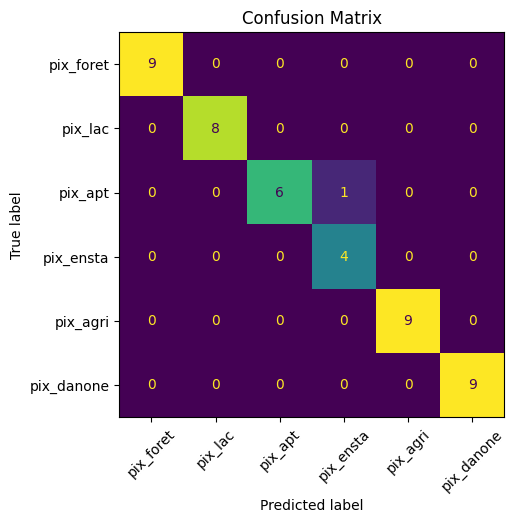

In [19]:
matrice = np.delete(matrice_ndvi,22,1)
opt_ = OPTICS(eps=3000, metric='precomputed').fit(matrice_dtw(matrice, euclidean))
yhat = opt_.labels_
display(yhat)
n_clusters = len(set(yhat)) - (1 if -1 in yhat else 0)
n_aberrantes = list(yhat).count(-1)
print("Nombre de clusters: %d" % n_clusters)
print("Nombre de point aberrantes: %d" % n_aberrantes)
eval_ = evaluator_de_experiences(yhat, pixels_de_interet, dic_de_pixels, matrice)
eval_.confusion_matrix()
display(eval_.metrics_classif())
display(eval_.metrics_clustering())

### Bande NDWI

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  2,  2,  2,  2,  2,  1,  1,  2,  2, -1,  1,  1,  1, -1,  1,  1,
        1,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  1,  1,  1,  1,  1,  1,
        1,  1,  1])

Nombre de clusters: 5
Nombre de point aberrantes: 2


,accuracy,f1_score
0,0.826923,0.75264


,calinski_harabasz_score
0,192.814305


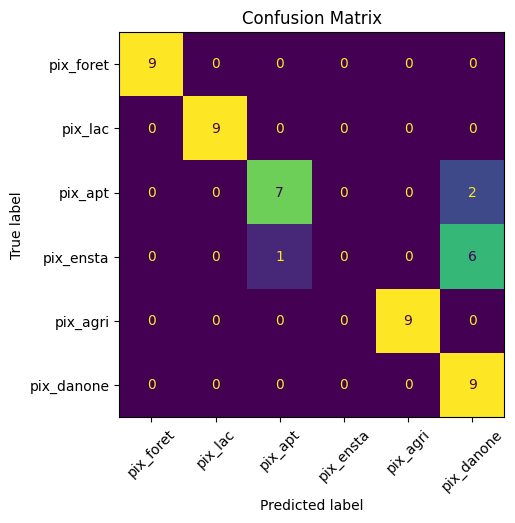

In [20]:
matrice = np.delete(matrice_ndwi,22,1)
opt_ = OPTICS(eps=3000, metric='precomputed').fit(matrice_dtw(matrice, euclidean))
yhat = opt_.labels_
display(yhat)
n_clusters = len(set(yhat)) - (1 if -1 in yhat else 0)
n_aberrantes = list(yhat).count(-1)
print("Nombre de clusters: %d" % n_clusters)
print("Nombre de point aberrantes: %d" % n_aberrantes)
eval_ = evaluator_de_experiences(yhat, pixels_de_interet, dic_de_pixels, matrice)
eval_.confusion_matrix()
display(eval_.metrics_classif())
display(eval_.metrics_clustering())

## CHA

### Bande verte

,accuracy,f1_score
0,0.5,0.436237


,calinski_harabasz_score
0,60.612554


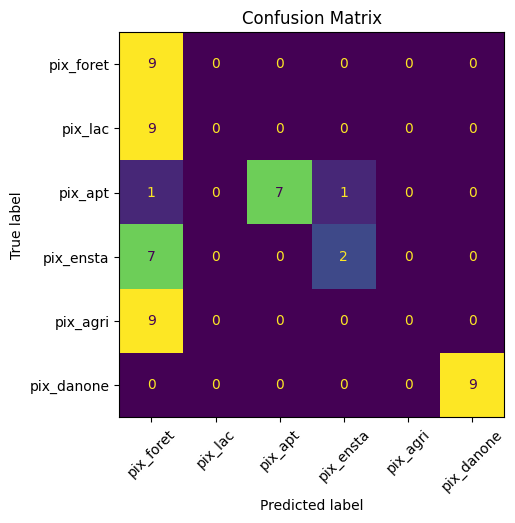

In [21]:
matrice = np.delete(matrice_vert,22,1)
cha_ = AgglomerativeClustering(n_clusters = 6, metric='precomputed', linkage='complete').fit(matrice_dtw(matrice, euclidean))
yhat = cha_.labels_

eval_ = evaluator_de_experiences(yhat, pixels_de_interet, dic_de_pixels, matrice)
eval_.confusion_matrix()
display(eval_.metrics_classif())
display(eval_.metrics_clustering())

# clustering_CAH_cos = AgglomerativeClustering(n_clusters=None, distance_threshold=30,metric='precomputed', linkage='complete').fit(matrice_dtw_cos)

### Bande Bleue

,accuracy,f1_score
0,0.481481,0.375199


,calinski_harabasz_score
0,73.652242


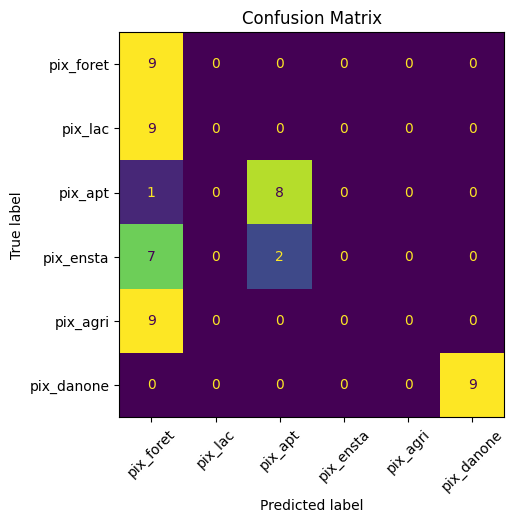

In [22]:
matrice = np.delete(matrice_bleu,22,1)
cha_ = AgglomerativeClustering(n_clusters = 6, metric='precomputed', linkage='complete').fit(matrice_dtw(matrice, euclidean))
yhat = cha_.labels_

eval_ = evaluator_de_experiences(yhat, pixels_de_interet, dic_de_pixels, matrice)
eval_.confusion_matrix()
display(eval_.metrics_classif())
display(eval_.metrics_clustering())

### Bande rouge

,accuracy,f1_score
0,0.648148,0.533513


,calinski_harabasz_score
0,88.385289


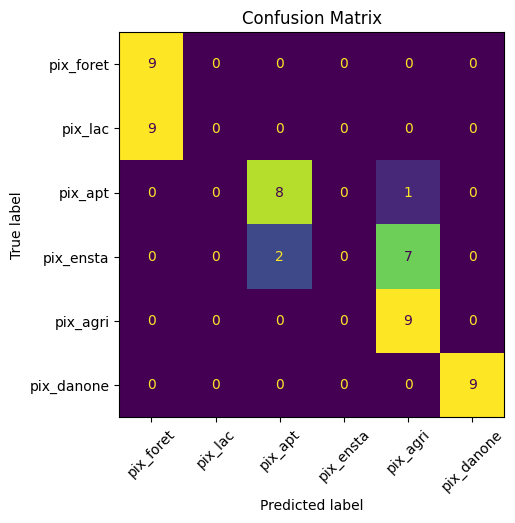

In [23]:
matrice = np.delete(matrice_rouge,22,1)
cha_ = AgglomerativeClustering(n_clusters = 6, metric='precomputed', linkage='complete').fit(matrice_dtw(matrice, euclidean))
yhat = cha_.labels_

eval_ = evaluator_de_experiences(yhat, pixels_de_interet, dic_de_pixels, matrice)
eval_.confusion_matrix()
display(eval_.metrics_classif())
display(eval_.metrics_clustering())

### Bande NIR

,accuracy,f1_score
0,0.851852,0.851852


,calinski_harabasz_score
0,111.530902


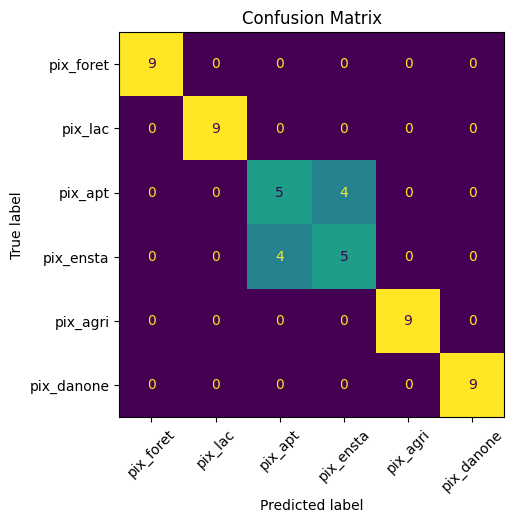

In [24]:
matrice = np.delete(matrice_nir,22,1)
cha_ = AgglomerativeClustering(n_clusters = 6, metric='precomputed', linkage='complete').fit(matrice_dtw(matrice, euclidean))
yhat = cha_.labels_

eval_ = evaluator_de_experiences(yhat, pixels_de_interet, dic_de_pixels, matrice)
eval_.confusion_matrix()
display(eval_.metrics_classif())
display(eval_.metrics_clustering())

### Bande NDVI

,accuracy,f1_score
0,0.759259,0.711111


,calinski_harabasz_score
0,161.814869


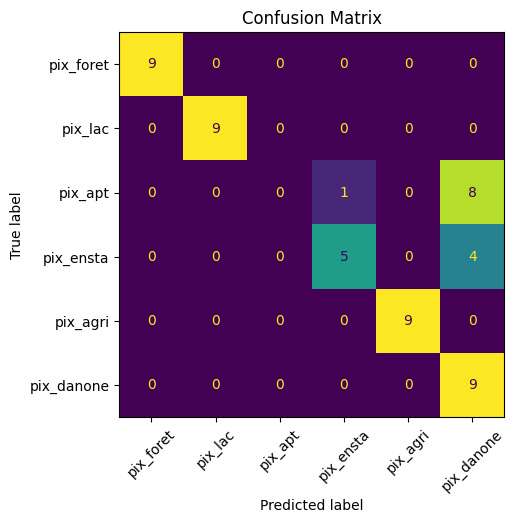

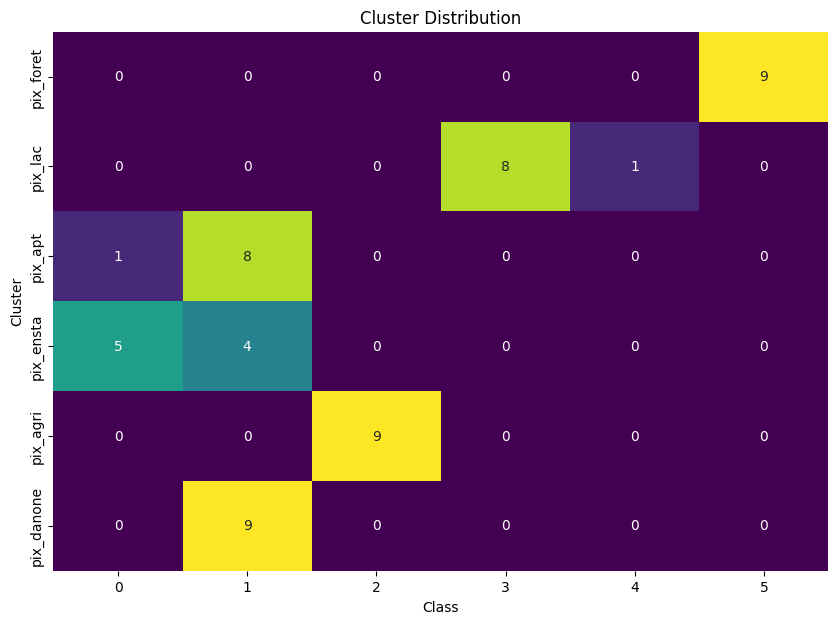

None

In [28]:
matrice = np.delete(matrice_ndvi,22,1)
cha_ = AgglomerativeClustering(n_clusters = 6, metric='precomputed', linkage='complete').fit(matrice_dtw(matrice, euclidean))
yhat = cha_.labels_

eval_ = evaluator_de_experiences(yhat, pixels_de_interet, dic_de_pixels, matrice)
eval_.confusion_matrix()
display(eval_.metrics_classif())
display(eval_.metrics_clustering())
display(eval_.cluster_distribution())

### Bande NDWI

,accuracy,f1_score
0,0.722222,0.660256


,calinski_harabasz_score
0,206.384053


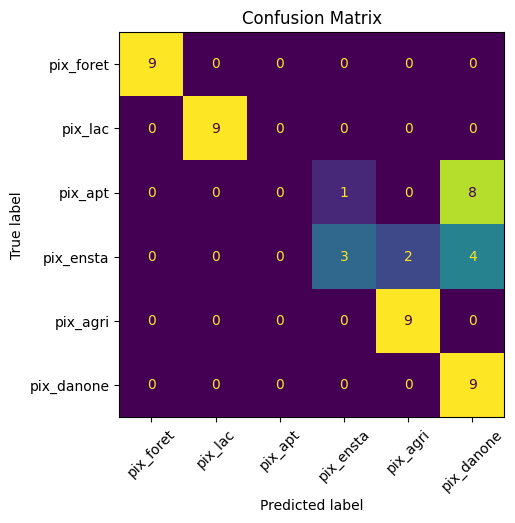

In [57]:
matrice = np.delete(matrice_ndwi,22,1)
cha_ = AgglomerativeClustering(n_clusters = 6, metric='precomputed', linkage='complete').fit(matrice_dtw(matrice, euclidean))
yhat = cha_.labels_

eval_ = evaluator_de_experiences(yhat, pixels_de_interet, dic_de_pixels, matrice)
eval_.confusion_matrix()
display(eval_.metrics_classif())
display(eval_.metrics_clustering())